In [116]:
from datetime import datetime
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.stattools import acf, pacf
from datetime import timedelta
from sklearn.metrics import root_mean_squared_error
import pickle
from sklearn.preprocessing import StandardScaler

# Filter out unnecceessary data

In [117]:
df = pd.read_csv("../dataset.csv", index_col="ts", parse_dates = True)
df.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-01 21:15:00,1,34.3262,33.3125,3262.0,84,27.9,0.1,100
2025-04-01 21:30:00,2,33.9057,33.4688,3232.5,84,27.8,0.1,100
2025-04-01 21:45:00,3,33.2979,33.5938,3218.0,85,27.8,0.1,100
2025-04-01 22:00:00,4,33.6201,33.3281,3211.0,85,27.6,0.0,100
2025-04-01 22:15:00,5,33.2979,33.3438,3203.0,85,27.6,0.0,100


In [118]:
df = df.resample('D').mean()
df.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-01,6.0,30.485055,33.485800,3211.045455,83.909091,28.200000,0.027273,96.363636
2025-04-02,46.0,27.144790,33.753629,3158.710145,62.623188,31.623188,0.000000,87.246377
2025-04-03,128.5,25.908357,33.485352,3121.473958,76.322917,29.742708,0.025000,81.854167
2025-04-04,224.5,25.931506,33.122399,3223.473958,72.354167,30.153125,0.000000,36.416667
2025-04-05,320.0,141.128589,33.805593,3099.052632,71.084211,30.283158,0.000000,63.873684


# EDA

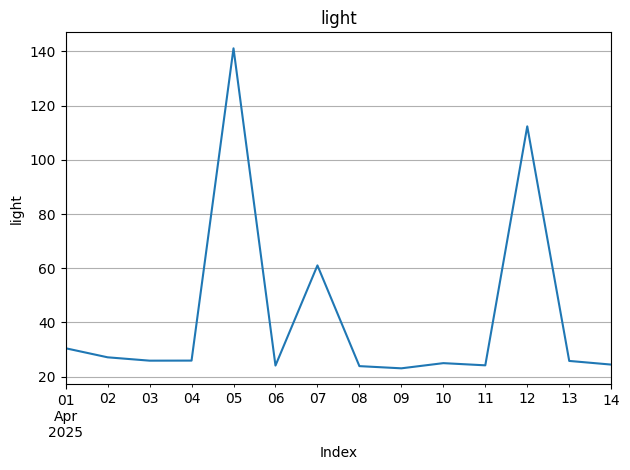

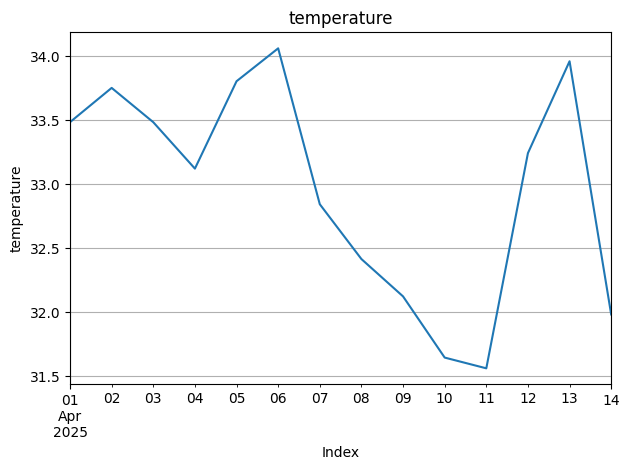

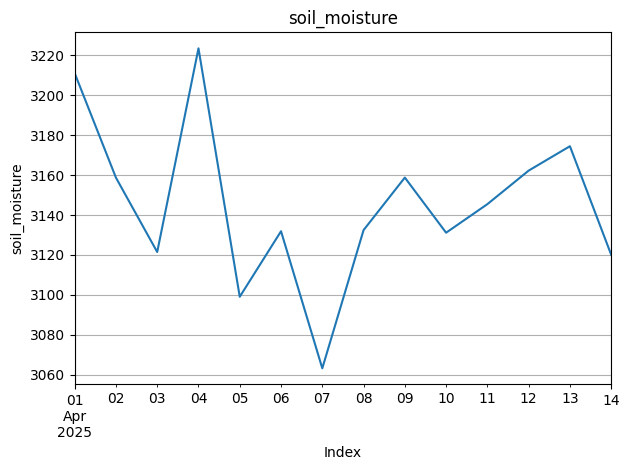

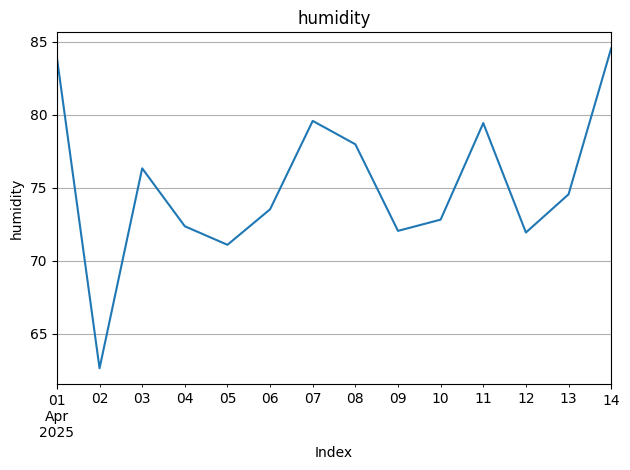

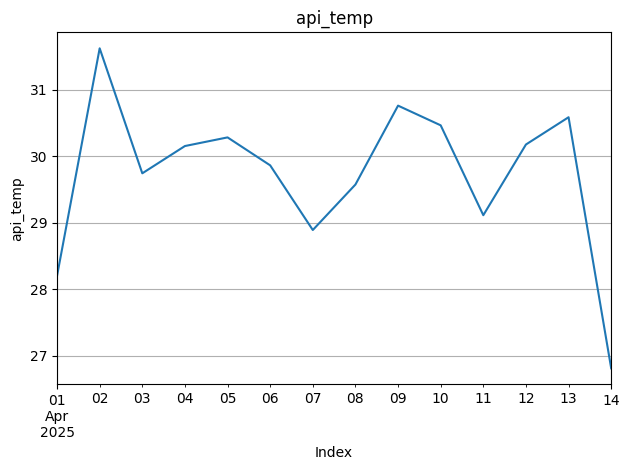

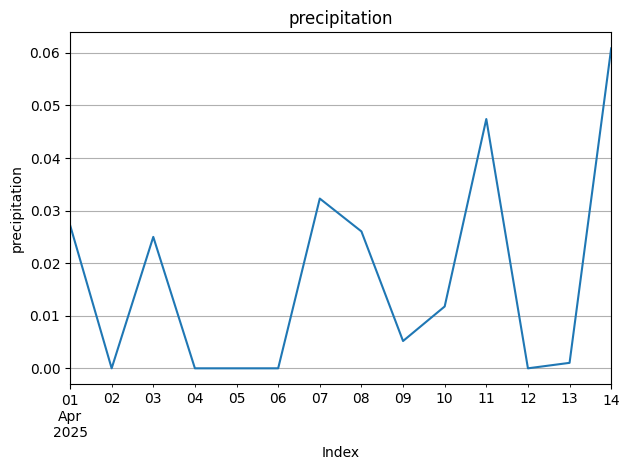

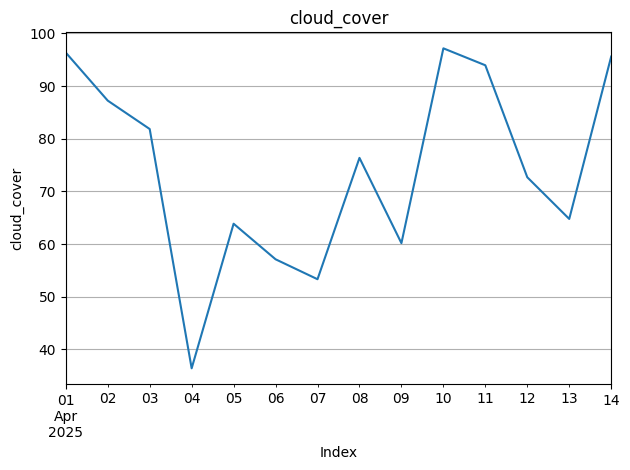

In [119]:
for column in df.columns:
    if column == "id":
        continue
    plt.figure()  # Create a new figure for each plot
    df[column].plot()
    plt.title(column)
    plt.xlabel("Index")  # or "Date" if it's time series
    plt.ylabel(column)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

<Axes: >

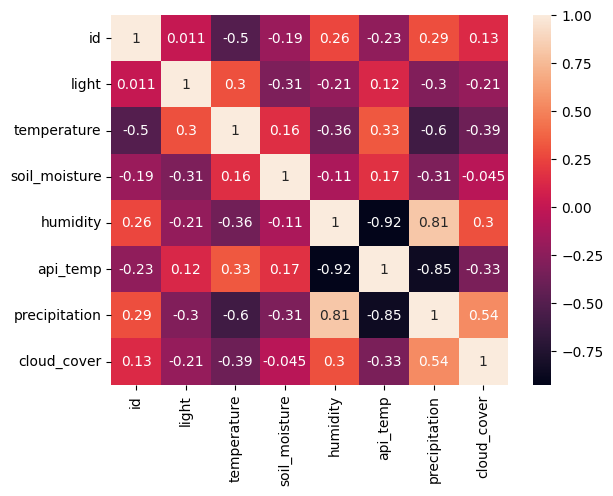

In [120]:
sns.heatmap(df.corr(),annot=True)

In [121]:
df["soil_moisture"].diff().dropna()

ts
2025-04-02    -52.335310
2025-04-03    -37.236187
2025-04-04    102.000000
2025-04-05   -124.421327
2025-04-06     32.826489
2025-04-07    -68.651725
2025-04-08     69.215312
2025-04-09     26.310538
2025-04-10    -27.613541
2025-04-11     14.303593
2025-04-12     16.791076
2025-04-13     12.218750
2025-04-14    -54.355299
Freq: D, Name: soil_moisture, dtype: float64

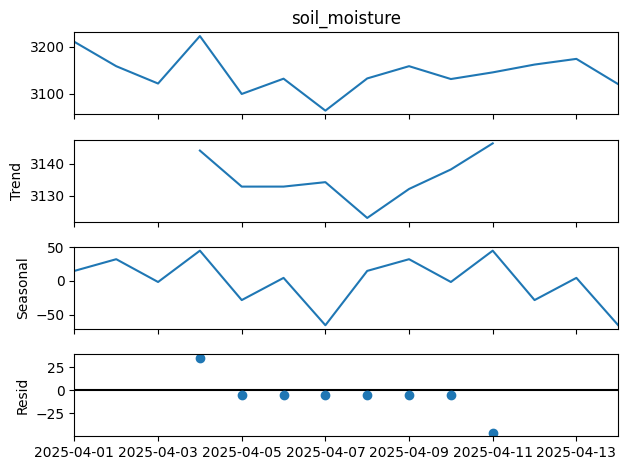

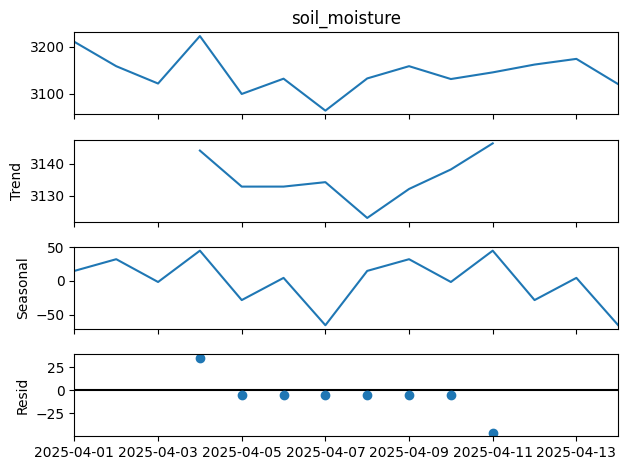

In [122]:
seasonal_decompose(df["soil_moisture"], model="additive").plot()


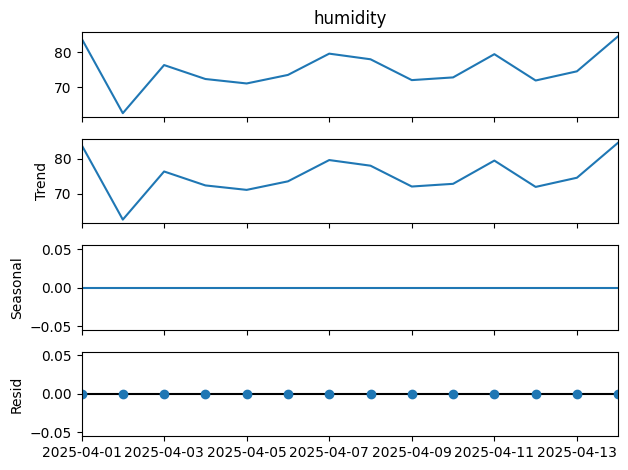

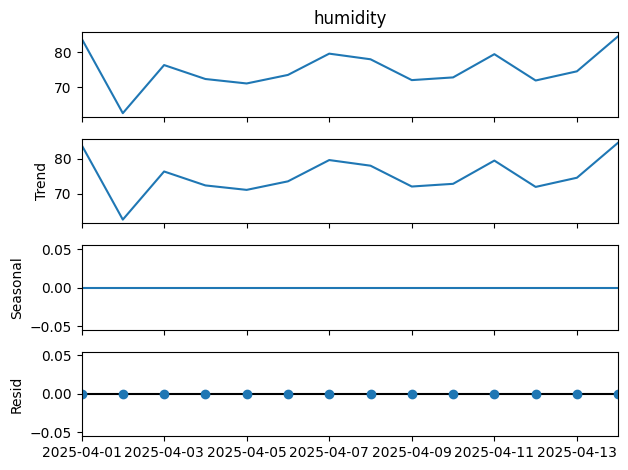

In [123]:
seasonal_decompose(df["humidity"], model="additive", period=1).plot()

## Find D parameter

In [124]:
result = adfuller(df["soil_moisture"].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -8.71883544046531
p-value: 3.4292979745286215e-14
Critial Values:
   1%, -4.6651863281249994
Critial Values:
   5%, -3.3671868750000002
Critial Values:
   10%, -2.802960625


Since p-value is less than 0.05, the data is stationary and no differencing is needed.

Therefore, we use d=0.

## Find P parameter

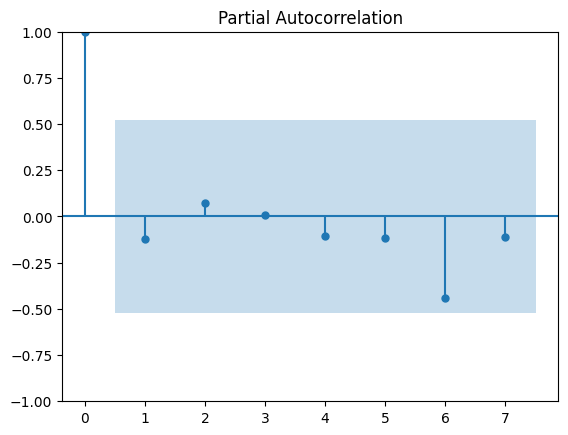

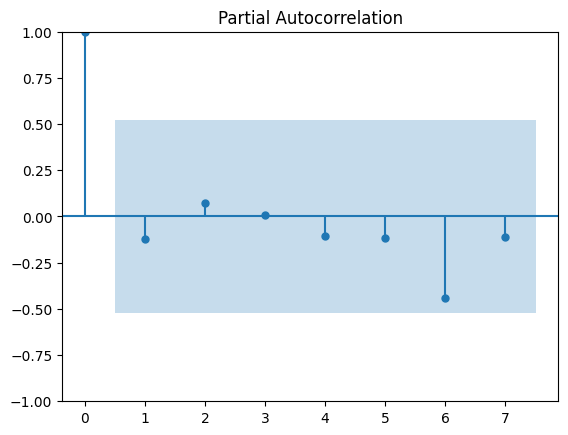

In [125]:
plot_pacf(df["soil_moisture"])


There are 1 exceptionally high bars, therefore, p=1

## Find Q parameter

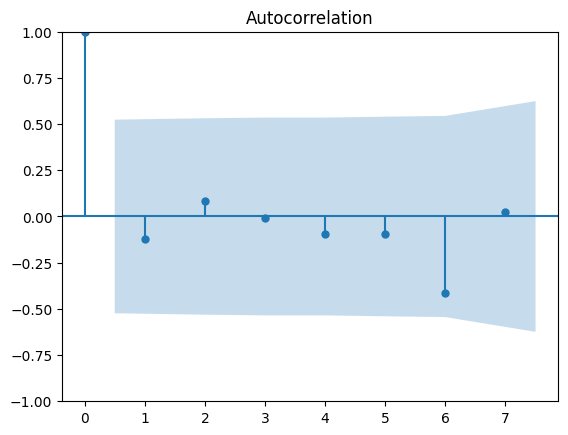

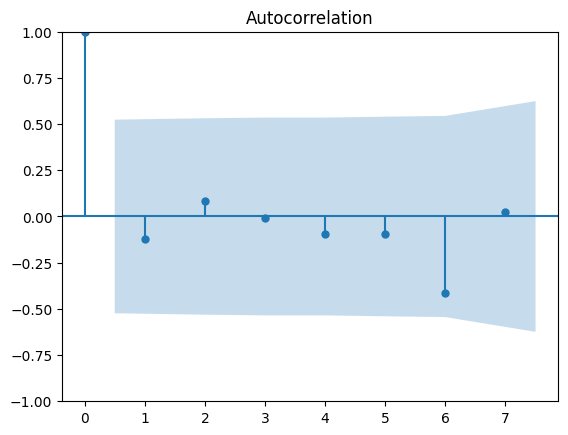

In [126]:
plot_acf(df["soil_moisture"])

There are 1 exceptionally high bars, therefore, q=1

# Pre-Processing

## Separate the test and train data

In [127]:
train_end = datetime(2025,4,9)
test_end = datetime(2025,4,11)

train_data = df[:train_end-timedelta(days=1)]
test_data = df[train_end:test_end]
# test_data = df[train_end + timedelta(days=1):test_end]
print(train_data)
print(test_data)


               id       light  temperature  soil_moisture   humidity  \
ts                                                                     
2025-04-01    6.0   30.485055    33.485800    3211.045455  83.909091   
2025-04-02   46.0   27.144790    33.753629    3158.710145  62.623188   
2025-04-03  128.5   25.908357    33.485352    3121.473958  76.322917   
2025-04-04  224.5   25.931506    33.122399    3223.473958  72.354167   
2025-04-05  320.0  141.128589    33.805593    3099.052632  71.084211   
2025-04-06  413.0   24.105108    34.063013    3131.879121  73.516484   
2025-04-07  506.5   61.050593    32.843917    3063.227396  79.572917   
2025-04-08  602.5   23.892697    32.415202    3132.442708  77.968750   

             api_temp  precipitation  cloud_cover  
ts                                                 
2025-04-01  28.200000       0.027273    96.363636  
2025-04-02  31.623188       0.000000    87.246377  
2025-04-03  29.742708       0.025000    81.854167  
2025-04-04  30.1531

In [128]:
train_data.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-01,6.0,30.485055,33.485800,3211.045455,83.909091,28.200000,0.027273,96.363636
2025-04-02,46.0,27.144790,33.753629,3158.710145,62.623188,31.623188,0.000000,87.246377
2025-04-03,128.5,25.908357,33.485352,3121.473958,76.322917,29.742708,0.025000,81.854167
2025-04-04,224.5,25.931506,33.122399,3223.473958,72.354167,30.153125,0.000000,36.416667
2025-04-05,320.0,141.128589,33.805593,3099.052632,71.084211,30.283158,0.000000,63.873684


In [129]:
test_data.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-09,689.0,23.082801,32.123174,3158.753247,72.038961,30.761039,0.005195,60.181818
2025-04-10,761.5,24.993522,31.644756,3131.139706,72.808824,30.464706,0.011765,97.176471
2025-04-11,844.0,24.186542,31.560729,3145.443299,79.422680,29.112371,0.047423,93.958763


In [130]:
train_data[["soil_moisture"]]

,soil_moisture
ts,
2025-04-01,3211.045455
2025-04-02,3158.710145
2025-04-03,3121.473958
2025-04-04,3223.473958
2025-04-05,3099.052632
2025-04-06,3131.879121
2025-04-07,3063.227396
2025-04-08,3132.442708


In [131]:
test_data['soil_moisture'].count()

3

In [132]:
test_data[['light', 'precipitation']]

,light,precipitation
ts,,
2025-04-09,23.082801,0.005195
2025-04-10,24.993522,0.011765
2025-04-11,24.186542,0.047423


# Train the model

Import the model to predict the exog values

In [133]:
# Import exog data predicting models 
with open('../exports/api_temp_sarima.pkl', 'rb') as file:
    api_temp_model = pickle.load(file)

with open('../exports/humidity_sarima.pkl', 'rb') as file:
    humidity_model = pickle.load(file)

with open('../exports/temperature_sarima.pkl', 'rb') as file:
    temperature_model = pickle.load(file)
    
with open('../exports/light_sarima.pkl', 'rb') as file:
    light_model = pickle.load(file)
    
with open('../exports/precipitation_sarima.pkl', 'rb') as file:
    precipitation_model = pickle.load(file)

In [134]:
light_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             light   No. Observations:                    8
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 3)   Log Likelihood                 -42.022
Date:                           Mon, 28 Apr 2025   AIC                             94.043
Time:                                   10:42:27   BIC                             94.440
Sample:                               04-01-2025   HQIC                            91.364
                                    - 04-08-2025                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.223      4.493      0.000       0.564       1.436
ma.L1         -0.9658      9.680     -0.100      0.921     -19.939      18.007
ar.S.L3       -0.9988      1.079     -0.926      0.355      -3.114       1.116
ma.S.L3        0.9763     10.786      0.091      0.928     -20.163      22.116
sigma2      1353.3963      0.010    1.4e+05      0.000    1353.377    1353.415
===================================================================================
Ljung-Box (L1) (Q):                   2.18   Jarque-Bera (JB):                 5.17
Prob(Q):                              0.14   Prob(JB):                         0.08
Heteroskedasticity (H):               1.73   Skew:                             1.71
Prob(H) (two-sided):                  0.66   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.15e+22. Standard errors may be unstable.
"""

In [135]:
# Predicting the data
forecast_steps = len(test_data)

# Get forecasts and rename columns immediately
exog_predictions = (
    precipitation_model.get_forecast(steps=forecast_steps)
    .predicted_mean
    .rename('precipitation')
    .to_frame()
)

light_predictions = (
    light_model.get_forecast(steps=forecast_steps)
    .predicted_mean
    .rename('light')
    .to_frame()
)

# temperature_predictions = (
#     temperature_model.get_forecast(steps=forecast_steps)
#     .predicted_mean
#     .rename('temperature')
#     .to_frame()
# )

# Combine exogenous variables
exog_predictions = pd.concat(
    [exog_predictions, light_predictions], 
    axis=1
)

# If using temperature:
# exog_predictions = pd.concat(
#     [exog_predictions, temperature_predictions], 
#     axis=1
# )

print(exog_predictions.columns)
print(test_data[['light', 'precipitation']])
exog_predictions.head()

Index(['precipitation', 'light'], dtype='object')
                light  precipitation
ts                                  
2025-04-09  23.082801       0.005195
2025-04-10  24.993522       0.011765
2025-04-11  24.186542       0.047423


,precipitation,light
2025-04-09,0.059648,43.768346
2025-04-10,0.106391,40.317933
2025-04-11,0.165445,62.120539


In [136]:
print("Training exog stats:")
print(train_data[['precipitation', 'light']].describe())

print("\nPrediction exog stats:")
print(exog_predictions.describe())

Training exog stats:
       precipitation       light
count       8.000000    8.000000
mean        0.013826   44.955837
std         0.014931   40.774672
min         0.000000   23.892697
25%         0.000000   25.457545
50%         0.012500   26.538148
75%         0.026349   38.126439
max         0.032292  141.128589

Prediction exog stats:
       precipitation      light
count       3.000000   3.000000
mean        0.110494  48.735606
std         0.053018  11.719371
min         0.059648  40.317933
25%         0.083019  42.043140
50%         0.106391  43.768346
75%         0.135918  52.944443
max         0.165445  62.120539


## Data Scaling

In [137]:
scaler = StandardScaler()
scaler.fit(train_data[['precipitation', 'light']])
train_exog_scaled = scaler.transform(train_data[['precipitation', 'light']])
train_exog_scaled = pd.DataFrame(train_exog_scaled, columns=['precipitation', 'light'], index=train_data.index)
prediction_exog_scaled = scaler.transform(exog_predictions[['precipitation', 'light']])
prediction_exog_scaled = pd.DataFrame(prediction_exog_scaled, columns=exog_predictions.columns, index=exog_predictions.index)

## Actual Prediction

In [138]:
model = SARIMAX(
    endog=train_data['soil_moisture'],
    exog=train_exog_scaled, # [['temperature','humidity','api_temp']],  # Use DataFrame/Series, not column name
    order=(0, 1, 0)
)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          soil_moisture   No. Observations:                    8
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -37.511
Date:                Mon, 28 Apr 2025   AIC                             81.023
Time:                        10:42:27   BIC                             80.860
Sample:                    04-01-2025   HQIC                            79.017
                         - 04-08-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
precipitation   -16.5241     13.384     -1.235      0.217     -42.755       9.707
light           -27.3359     13.072     -2.091      0.037     -52.957      -1.715
sigma2         2643.2524   2232.893      1.184      0.237   -1733.137    7019.642
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.31
Prob(Q):                              0.82   Prob(JB):                         0.86
Heteroskedasticity (H):               0.16   Skew:                             0.24
Prob(H) (two-sided):                  0.28   Kurtosis:                         2.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [139]:
prediction = results.get_forecast(steps = int(test_data['soil_moisture'].count()), exog=prediction_exog_scaled).predicted_mean
prediction.columns = ['predicted']
prediction

2025-04-09    3078.437817
2025-04-10    3025.607470
2025-04-11    2940.113241
Freq: D, Name: predicted_mean, dtype: float64

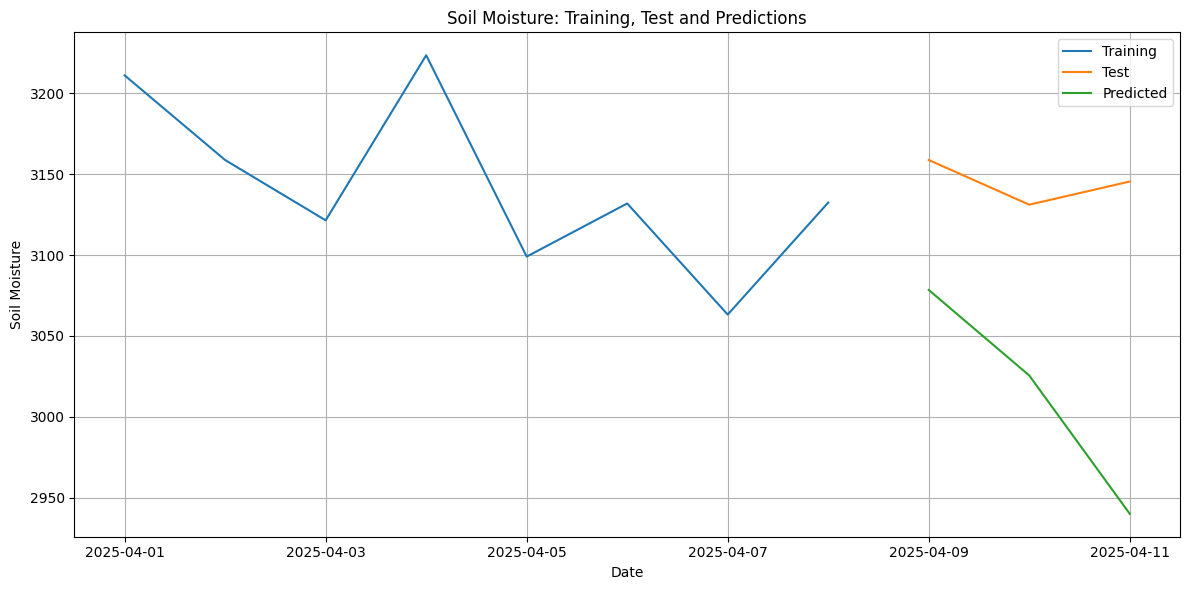

RMSE :  141.12412237853528


In [140]:
plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["soil_moisture"], label="Training")
plt.plot(test_data.index, test_data["soil_moisture"], label="Test")
plt.plot(test_data.index, prediction, label="Predicted")  # use the same x-axis as test

plt.legend()
plt.xlabel("Date")
plt.ylabel("Soil Moisture")
plt.title("Soil Moisture: Training, Test and Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()

print("RMSE : ", root_mean_squared_error(test_data['soil_moisture'], prediction))


## Exporting the trained model with Pickle for external uses.

**Warning** : Do not unpickle untrusted model because it might execute a malicious code hidden in the model file.

In [141]:
with open('../exports/plant_water.pkl', 'wb') as file:
    pickle.dump(results, file)